Vna_files
Prosesamiento de datos



In [ ]:
# !pip install git+https://github.com/dpk2442/pysmith.git#egg=pysmith

import numpy as np
import matplotlib.pyplot as plt
import cmath
from datetime import datetime
from scipy.optimize import fsolve

# import pysmith

In [ ]:
# https://pysmith.readthedocs.io/en/latest/

file_path = '/content/'
# file_path = '/content/rsc/'
file_name = [
# Mediciones del 15/11/23
            'Aire_15-11.s1p',#0
            'agua_15-11.s1p',#1
            'Acetona_15-11.s1p',#2
            'PLA_15-11.s1p',#3
            'ABS diluido_15-11.s1p',#4
            'alcohol_15-11.s1p',#5
            'dedo_15-11.s1p',#6
# Mediciones del 08/11/23
            'AIRE_8-11.s1p', #7
            'Agua_destilada_8-11.s1p',#8
            'resina_8-11.s1p',#9
            'Acetona_8-11.s1p',#10
            'azucar_8-11.s1p', #11
            'Alcohol_8-11.s1p', #12
          ]
def vna_proc_file(file_path, file_name):
    file_path += file_name
    header_start  = '#'
    data_start    = '!'
    out_dict = {'Data' : [],
                     'Index': [],
                     'Frec' : [],
                    }

    frecuencies = np.array([])
    reals       = np.array([])
    imgs        = np.array([])

    try:
        file = open(file_path, "r")
    except:
        print('TODO: No se puede abrir')
        return 404

    file_list = file.readlines()
    # print(file_list)
    file.close()

    for line in file_list[12:]:
        values      = line.strip().split('\t')
        frecuencies = np.append(frecuencies, np.float32(values[0]))
        reals       = np.append(reals, np.float32(values[1]))
        imgs        = np.append(imgs, np.float32(values[2]))

    out_dict['Data'   ] = file_list[0:11]
    out_dict['Index'  ] = file_list[11][1:].split(' ')
    out_dict['Frec'   ] = frecuencies
    out_dict['Img'    ] = imgs
    out_dict['Real'   ] = reals
    out_dict['Complex'] = reals +1j*imgs

    return out_dict

Conversión de parámetros

In [ ]:
def S11_to_Y11(frec, S11):
    z0 = 50
    y0 = 1/z0
    Y11 = y0*(( 1 - S11 ) / ( 1 + S11 ))
    return { 'Frec'    : frec,
             'Complex' : Y11,
            }

def get_debye_model(frecs):
    w     = frecs*2*np.pi
    E_inf = 4.6
    E_s   = 78.3
    # E_s   = 23.65
    # E_inf = 4.471
    tau   = 8.07e-12
    # tau   = 1/1.124
    # print(tau)
    E_c   = E_inf + (E_s-E_inf)/(1-1j*w*tau)
    # print(E_c)
    return E_c

# Define the equation
def Yin_transm_line(Ec, Frecs, Y11, C0, G0):
    W  = 2*np.pi*Frecs
    return ((np.real(1j * W * Ec * C0 + Ec**(5/2) * G0) - Y11.real) + np.imag(1j * W * Ec * C0 + Ec**(5/2) * G0) - Y11.imag)

def system_equations(variables, *params):
    C0 = variables[0]
    G0 = variables[1]
    Ec, Frecs, Y11 = params

    W = 2 * np.pi * Frecs
    equation1 = np.real(1j * W * Ec * C0 + Ec**(5/2) * G0) - Y11.real
    equation2 = np.imag(1j * W * Ec * C0 + Ec**(5/2) * G0) - Y11.imag

    return np.concatenate([equation1, equation2])

def system_equations_2(Ec, *params):
    Frecs, Y11, C0, G0 = params

    W = 2 * np.pi * Frecs
    equation1 = np.real(1j * W * Ec * C0 + Ec**(5/2) * G0) - Y11.real
    equation2 = np.imag(1j * W * Ec * C0 + Ec**(5/2) * G0) - Y11.imag

    return np.concatenate([equation1, equation2])

def solve_Yin_transm_line(Ec, Frecs, Y11, C0_guess, G0_guess):
    params = (Ec, Frecs, Y11)
    initial_guess = [C0_guess, G0_guess]  # Using the first values of the arrays
    C0 = []
    G0 = []
    SOLUTION = fsolve(system_equations, initial_guess, args=params)

    return SOLUTION

def solve_Ec_from_C0_G0(C0, G0, Y11, Frecs, Ec_guess):
    params = (Frecs, Y11, C0, G0)

    Ec_result = fsolve(system_equations_2, Ec_guess, args=params)

    return Ec_result

In [ ]:

def ecuacion_trascendental(E, W, C, G, Y):
  return (1j * W * E * C + G*(E**2.5)) - Y # dan igual
#  return 1j * W * E * C + cmath.exp(2.5 * cmath.log(E**2)) * G - Y

def derivada_ecuacion_trascendental(E, W, C, G):
  return (1j*W*C + (5/2)*G*(E**2.5)/E) # dan igual
  # return 1j * W * C + 5 * cmath.exp(2.5 * cmath.log(E**2)) * G / (2 * E)

def Calculo_Ec(Y, f, C, G, E_inicial=(1 + 1j), tolerancia=(5e-2), max_iteraciones=10000):
    W = 2*np.pi*f
    E = E_inicial

    for _ in range(max_iteraciones):
        f = ecuacion_trascendental(E, W, C, G, Y)
        f_prime = derivada_ecuacion_trascendental(E, W, C, G)
        E -= f / f_prime
        if (abs(f) < tolerancia):
          # print('f:',f,'E:',E)
          return E

    print('dif: ',abs(f), 'E: ',E)
    raise RuntimeError("No se pudo converger a una solución en las iteraciones dadas.")

def Calculo_Ec_dic(Y11, CoGo):
  if np.array_equal(Y11['Frec'], CoGo['Frec']):

    Ec_dict = {'Frec': Y11['Frec'], 'Eo': []}
    Y_d     = Y11['Complex']
    frec_d  = Y11['Frec']
    Co_d    = CoGo['Co']
    Go_d    = CoGo['Go']
    #print(frec_d)
    # Iterar
    for Y_, frec_, Co_, Go_  in zip(Y_d, frec_d, Co_d, Go_d):
      #print('Y_=',Y_)
      #print('Frec_=',frec_)
      #print('Co_=',Co_)
      #print('Go_=',Go_)
      # Ec_dict['Frec'].append(frec_)

      if Ec_dict['Eo']:
        Ec_dict['Eo'].append(Calculo_Ec(Y_,frec_,Co_, Go_,Ec_dict['Eo'][-1]))
      else:
        Ec_dict['Eo'].append(Calculo_Ec(Y_,frec_,Co_, Go_))

    Ec_dict['Eo'] = np.asarray(Ec_dict['Eo'])
      #print('Eo = ',Ec_dict['Eo'][-1],' , F = ',Ec_dict['Frec'][-1])
    return  Ec_dict

  else:
    print('TODO: arrays diferente tamaño')
    return 404

In [ ]:
dictionary_aire = vna_proc_file(file_path, file_name[7])
# dictionary_aire = vna_proc_file(file_path, file_name[0])
Y11_aire = S11_to_Y11(dictionary_aire['Frec'], dictionary_aire['Complex'])

dictionary_agua = vna_proc_file(file_path, file_name[8])
Ec_agua_dest    = get_debye_model(dictionary_agua['Frec'])
Y11_agua        = S11_to_Y11(dictionary_agua['Frec'], dictionary_agua['Complex'])

In [ ]:
C0_guess = np.ones(len(Y11_agua['Frec'])) * 1e-12
G0_guess = np.ones(len(Y11_agua['Frec'])) * 1e-6

SOLUTION = solve_Yin_transm_line(Ec_agua_dest, Y11_agua['Frec'], Y11_agua['Complex'], C0_guess, G0_guess)

In [ ]:
C0 = SOLUTION[:(int)(len(SOLUTION)/2)]
G0 = SOLUTION[(int)(len(SOLUTION)/2):]

In [ ]:
len(C0)

In [ ]:

# # Create a 2D array with columns: frequency, real part, imaginary part

output_array = np.column_stack((Y11_agua['Frec'], dictionary_agua['Complex'], Y11_agua['Complex'],Ec_agua_dest, C0, G0))

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
out_h2o_file_name = f"AGUA_DEST_PROC_{timestamp}.csv"
np.savetxt(out_h2o_file_name, output_array, delimiter=',', header='S11, Y11, EC, C0, G0', comments='')


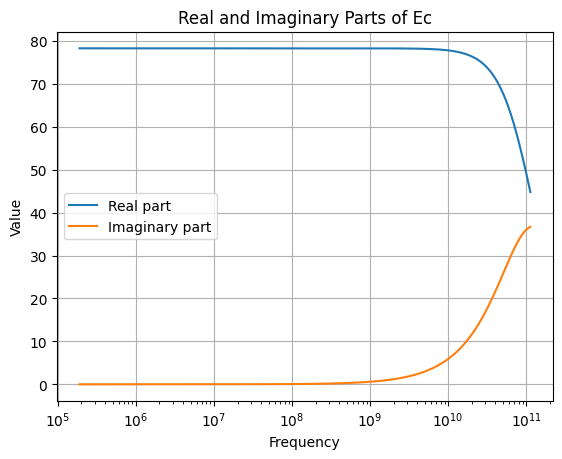

In [ ]:
frequency    = Y11_agua['Frec']
complex_data = Ec_agua_dest

# Plot real part
plt.plot(frequency * 2 * np.pi, np.real(complex_data), label='Real part')

# Plot imaginary part
plt.plot(frequency * 2 * np.pi,np.imag(complex_data), label='Imaginary part')

# Set labels and title
plt.title('Real and Imaginary Parts of Ec')
plt.xlabel('Frequency')
plt.ylabel('Value')
plt.xscale('log')
# Add a legend to distinguish real and imaginary parts
plt.legend()

# Display the plot
plt.grid(True)
plt.show()

In [ ]:
CoGo = {'Frec': Y11_agua['Frec'],
        'Co': C0,
        'Go': G0}

In [ ]:
Ec_guess = get_debye_model(Y11_agua['Frec'])

In [ ]:
len(Ec_guess)

10001

In [ ]:
file_name

['Aire_15-11.s1p',
 'agua_15-11.s1p',
 'Acetona_15-11.s1p',
 'PLA_15-11.s1p',
 'ABS diluido_15-11.s1p',
 'alcohol_15-11.s1p',
 'dedo_15-11.s1p',
 'AIRE_8-11.s1p',
 'Agua_destilada_8-11.s1p',
 'resina_8-11.s1p',
 'Acetona_8-11.s1p',
 'azucar_8-11.s1p',
 'Alcohol_8-11.s1p']

In [ ]:
len(out_Y11['Complex'])

10001

In [ ]:
for mat_file in file_name[7:]:
  out_dict = vna_proc_file(file_path, mat_file)
  out_Y11  = S11_to_Y11(out_dict['Frec'], out_dict['Complex'])
  out_Ec   = Calculo_Ec_dic(out_Y11, CoGo)
  output_array = np.column_stack((np.real(out_Y11['Frec']), out_dict['Complex'], out_Y11['Complex'], CoGo['Co'], CoGo['Go'], out_Ec['Eo']))
  timestamp = datetime.now().strftime("%d%H%M%S")
  out_file_name = file_path + 'out/'+ mat_file[:(len(mat_file)-8)] + f"_{timestamp}.txt"
  np.savetxt(out_file_name, output_array, delimiter='\t', header='Frequency S11 Y11 Co  Go  Eo', comments=''+datetime.now().strftime("%d %m %Y %H:%M:%S") +'\t\n')



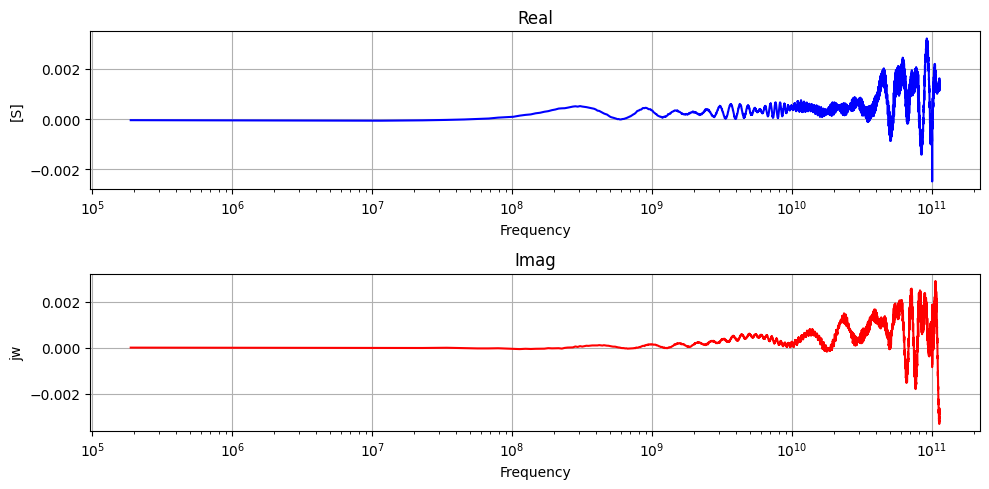

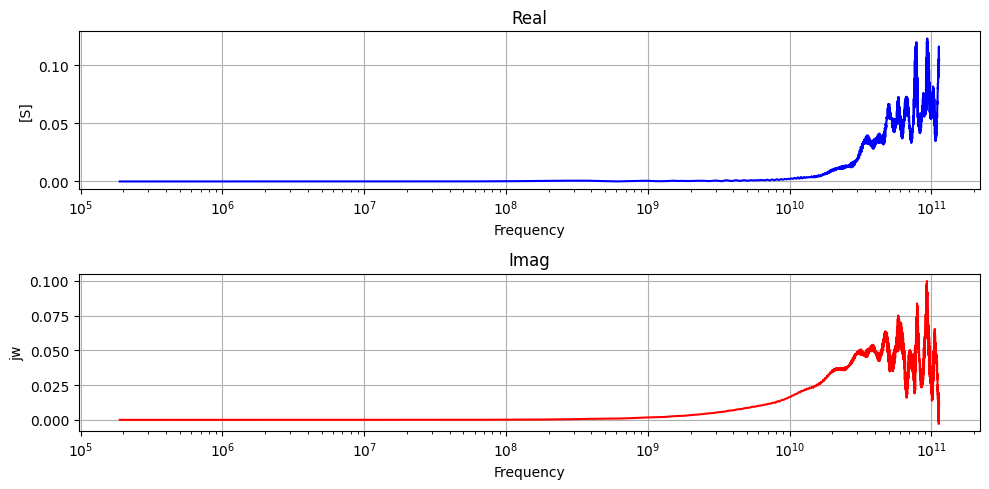

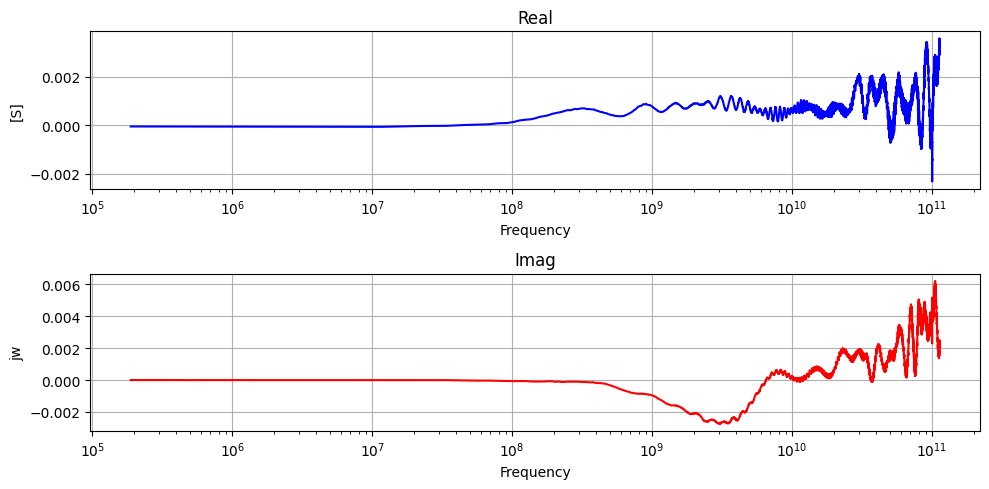

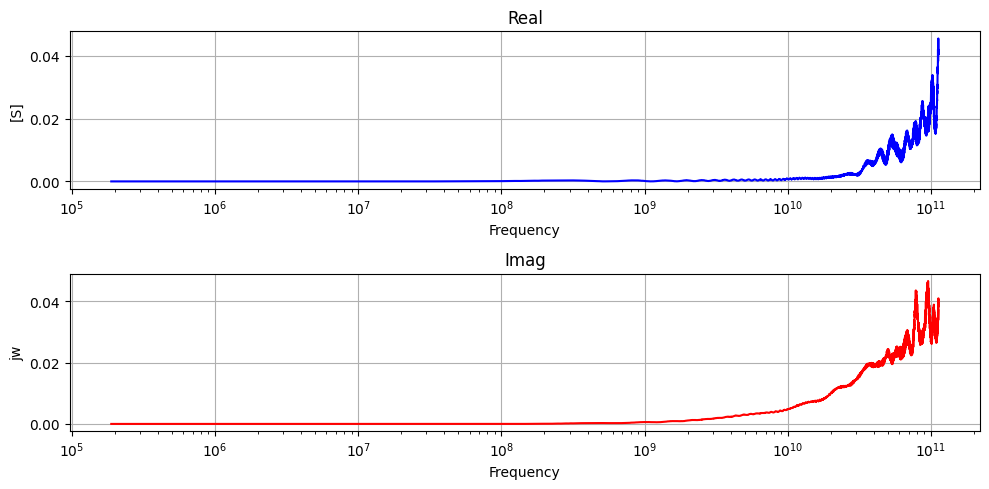

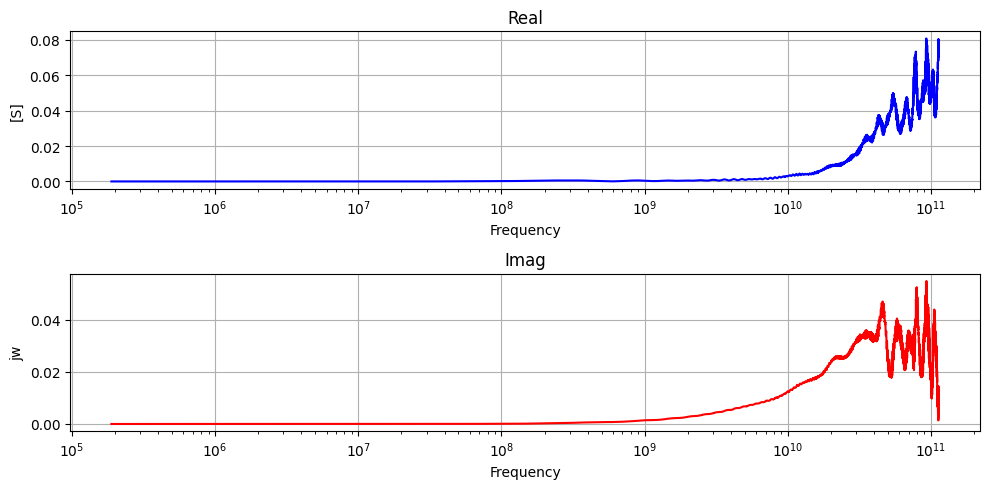

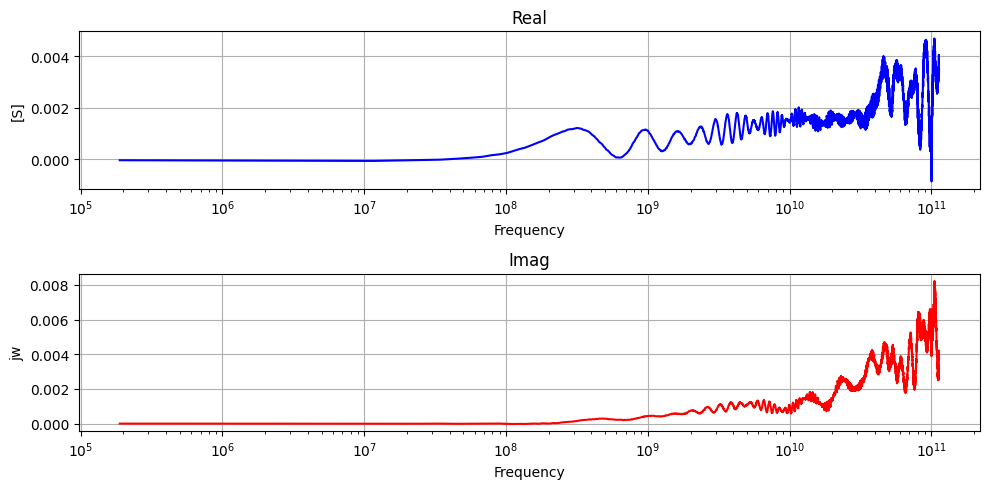

In [ ]:
for mat_file in file_name[7:]:
  out_dict = vna_proc_file(file_path, mat_file)
  out_Y11  = S11_to_Y11(out_dict['Frec'], out_dict['Complex'])
  out_Ec   = Calculo_Ec_dic(out_Y11, CoGo)

  plt.figure(figsize=(10, 5))
  plt.subplot(2, 1, 1)
  plt.xscale("log")
  plt.plot(out_dict['Frec']*2*np.pi, np.real(out_Y11['Complex']),  color='b')
  plt.title('Real')
  plt.xlabel('Frequency')
  plt.ylabel('[S]')
  plt.grid(True)
  plt.subplot(2, 1, 2)
  plt.xscale("log")
  plt.plot(out_dict['Frec']*2*np.pi, np.imag(out_Y11['Complex']), color='r')
  plt.title('Imag')
  plt.xlabel('Frequency')
  plt.ylabel('jw')
  plt.grid(True)
  plt.tight_layout()
  timestamp = datetime.now().strftime("%d%H%M%S")
  out_file_name = file_path + 'out/'+ mat_file[:(len(mat_file)-8)] + f"_{timestamp}.png"
  # plt.savefig(out_file_name)

AIRE_8-11.s1p


/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


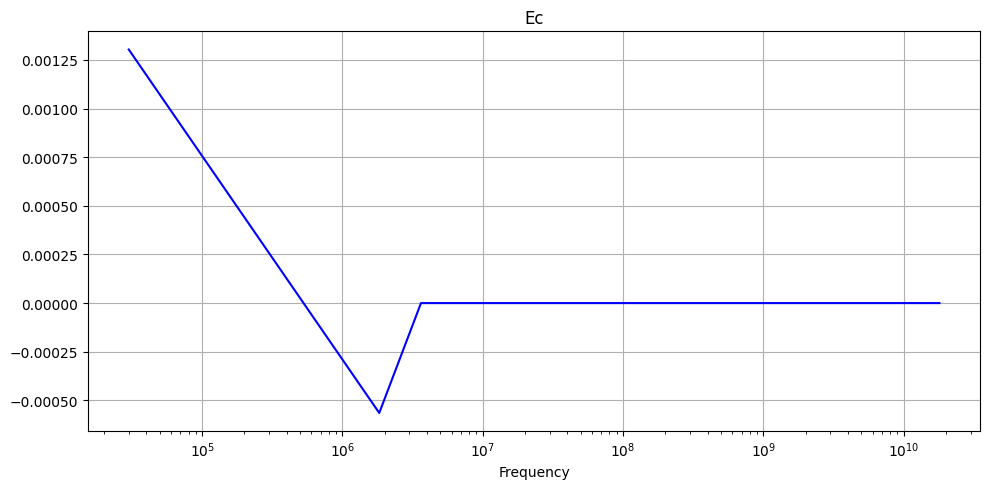

Agua_destilada_8-11.s1p


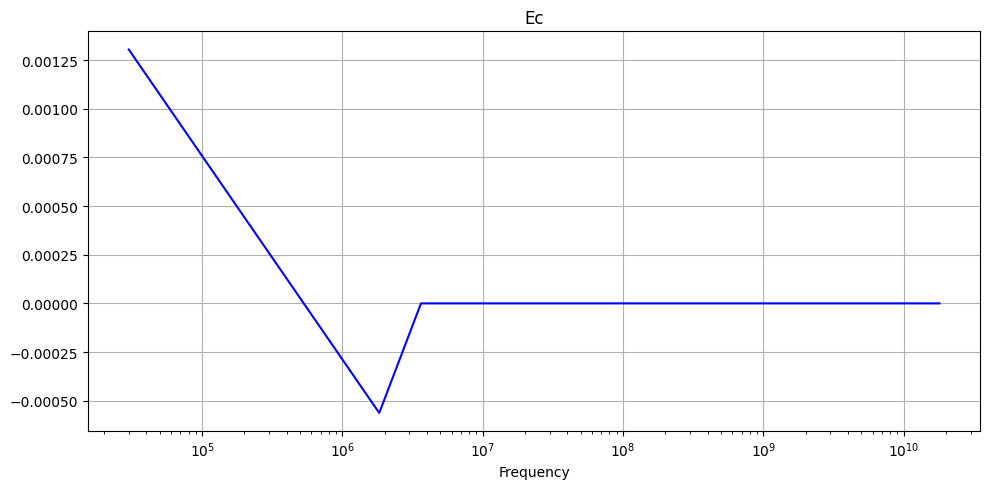

resina_8-11.s1p


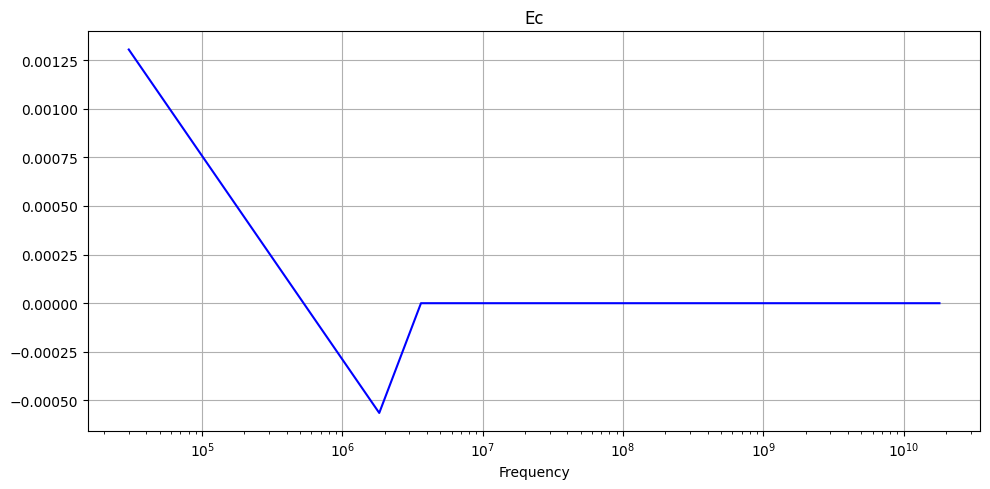

Acetona_8-11.s1p


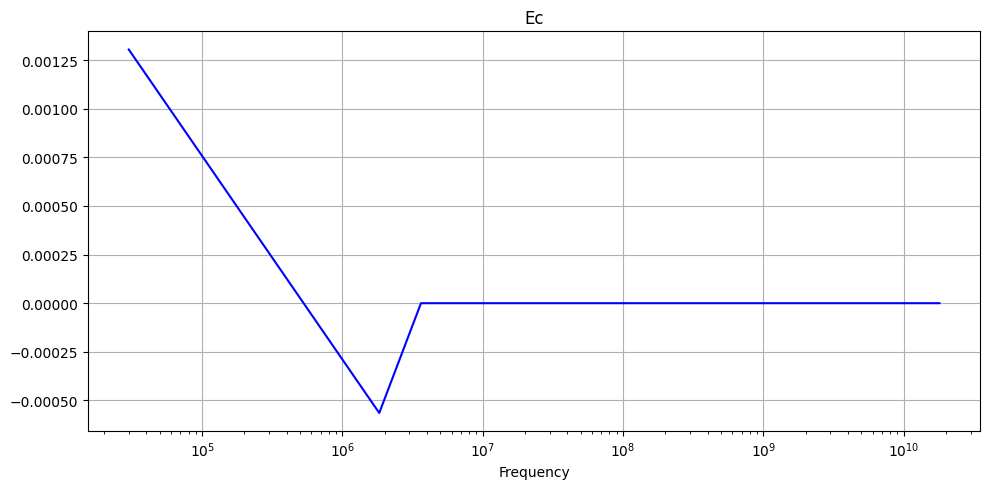

azucar_8-11.s1p


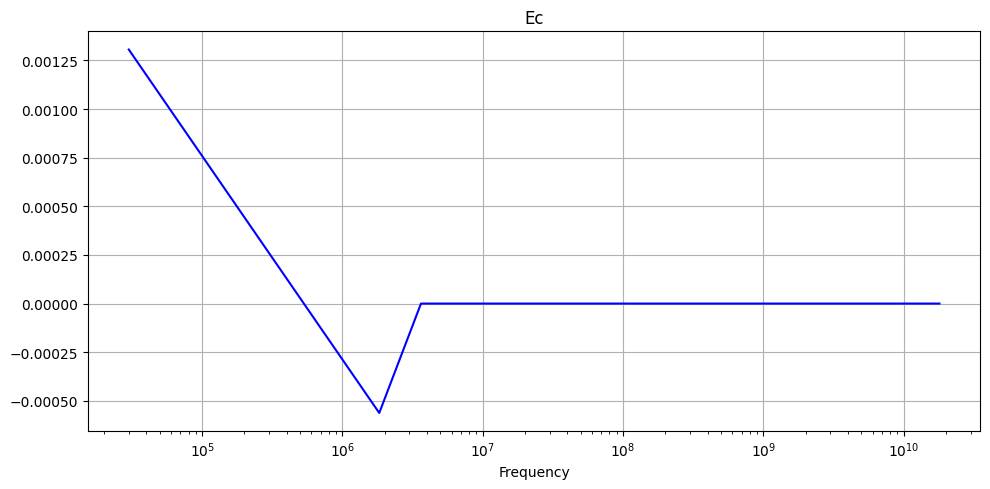

Alcohol_8-11.s1p


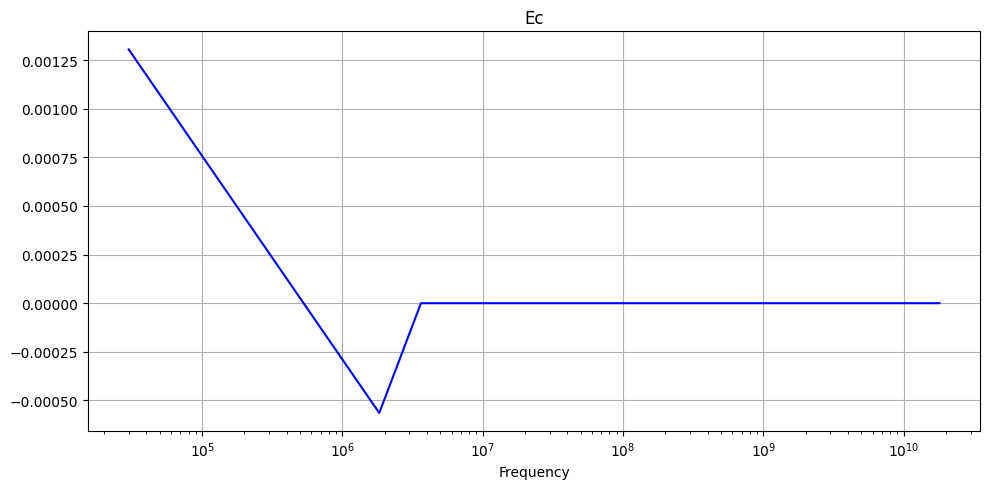

In [ ]:
for mat_file in file_name[7:]:
  print(mat_file)
  out_dict = vna_proc_file(file_path, mat_file)
  out_Y11  = S11_to_Y11(out_dict['Frec'], out_dict['Complex'])
  out_Ec   = Calculo_Ec_dic(out_Y11, CoGo)

  plt.figure(figsize=(10, 5))
  # plt.subplot(3, 1, 1)

  plt.plot(out_dict['Frec'], out_Ec['Eo'],  color='b')
  plt.title('Ec')
  plt.xlabel('Frequency')
  plt.xscale('log')
  plt.grid(True)
  plt.tight_layout()
  plt.show()
  timestamp = datetime.now().strftime("%d%H%M%S")
  out_file_name = file_path + 'out/'+ 'Ec_' + mat_file[:(len(mat_file)-8)] + f"_{timestamp}.png"
  # plt.savefig(out_file_name)